In [1]:
from proj_utils import *
import os, struct
import numpy as np
import cv2

In [2]:
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import SGD
import numpy as np
from IPython.display import SVG
from keras.applications.inception_v3 import InceptionV3
from keras.utils.vis_utils import model_to_dot

from keras.preprocessing.image import ImageDataGenerator

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
path = os.path.join(os.path.curdir, 'data')
x_train, y_train = load_NMNIST('training', digits=[0,1,2], path=path)
x_test, y_test = load_NMNIST('testing', digits=[0,1,2], path=path)

x_train = np.reshape(x_train, (len(x_train), 28,28, 1))
x_test = np.reshape(x_test, (len(x_test), 28,28, 1))

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [4]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

def aug_img(img):
    #img = np.reshape(img, (len(img), 28*28*1))
    #img = min_max_scaler.fit_transform(img)
    img = np.reshape(img, (len(img), 28,28, 1))
    img = np.repeat(img, 3, 3)
    img = resize_data(img)
    return img.astype(uint8)

In [5]:
x_train = aug_img(x_train)
x_test = aug_img(x_test)

In [6]:
data_gen_args = dict(#featurewise_center=True,
                     #featurewise_std_normalization=True,
                     #zca_whitening = True,
                     rotation_range=360,
                     width_shift_range=0.45,
                     height_shift_range=0.45,
                     rescale=1./255,
                     shear_range=0.4,
                     zoom_range=0.5,
                     horizontal_flip=True,
                     vertical_flip=True,
                     #preprocessing_function=aug_img,
                     fill_mode='nearest')
val_gen_args = dict(#featurewise_center=True,
                     #featurewise_std_normalization=True,
                     #zca_whitening = True,
                     #rotation_range=360,
                     #width_shift_range=0.2,
                     #height_shift_range=0.2,
                     rescale=1./255,
                     #shear_range=0.2,
                     #zoom_range=0.2,
                     #horizontal_flip=True,
                     #vertical_flip=True,
                     #preprocessing_function=aug_img,
                     fill_mode='nearest')

In [7]:
inc_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(140, 140, 3))

# get layers and add average pooling layer
x = inc_model.output
x = GlobalAveragePooling2D()(x)

# add fully-connected layer
#x = Dense(512, activation='relu')(x)
#x = Dense(256, activation='relu')(x)
#x = Dense(128, activation='relu')(x)
#x = Dense(64, activation='relu')(x)
#x = Dense(32, activation='relu')(x)
#x = Dense(16, activation='relu')(x)

# add output layer
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=inc_model.input, outputs=predictions)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [8]:
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
checkpoint_filename = 'InceptionV3.best_weights.hdf5'
callback_list = [TensorBoard(log_dir='/tmp/InceptionV3'),
                 EarlyStopping(monitor='val_loss', patience=25),
                 ModelCheckpoint(checkpoint_filename, monitor='val_loss', verbose=1, save_best_only=True),
                 ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=2, factor=0.5)]

In [9]:
# choose the layers which are updated by training
layer_num = len(model.layers)
for layer in model.layers[:100]:
    layer.trainable = False

for layer in model.layers[100:]:
    layer.trainable = True

# training
model.compile(optimizer=SGD(lr=0.001, momentum=0.5), loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [10]:
train_datagen = ImageDataGenerator(**data_gen_args)
test_datagen = ImageDataGenerator(**val_gen_args)

train_generator = train_datagen.flow(x_train, y_train,
                                     #target_size=(img_width, img_height),
                                     #class_mode='categorical',
                                     batch_size=128)
validation_generator = test_datagen.flow(x_test, y_test)

In [11]:
checkpoint_filename = 'InceptionV3.best_weights.hdf5'
model.load_weights(checkpoint_filename)

In [12]:
history = model.fit_generator(
                                generator=train_generator,
                                steps_per_epoch=x_train.shape[0] // 128,
                                epochs=5,
                                validation_data=validation_generator,
                                validation_steps=x_test.shape[0] // 128,
                                callbacks=callback_list)
                                #use_multiprocessing=True,
                                #shuffle=True)

Epoch 1/5
468/468 [==============================] - 144s 307ms/step - loss: 0.0934 - acc: 0.9616 - val_loss: 0.0562 - val_acc: 0.9780
Epoch 2/5
468/468 [==============================] - 128s 274ms/step - loss: 0.0913 - acc: 0.9622 - val_loss: 0.0524 - val_acc: 0.9800
Epoch 3/5
468/468 [==============================] - 130s 277ms/step - loss: 0.0889 - acc: 0.9630 - val_loss: 0.0557 - val_acc: 0.9788
Epoch 4/5
468/468 [==============================] - 130s 278ms/step - loss: 0.0851 - acc: 0.9650 - val_loss: 0.0539 - val_acc: 0.9796
Epoch 5/5
468/468 [==============================] - 130s 278ms/step - loss: 0.0872 - acc: 0.9641 - val_loss: 0.0537 - val_acc: 0.9804


In [13]:
model.load_weights(checkpoint_filename)
iv3_test_scores = model.evaluate_generator(validation_generator)
print("Accuracy: %.2f%%" % (iv3_test_scores[1]*100))

Accuracy: 98.07%


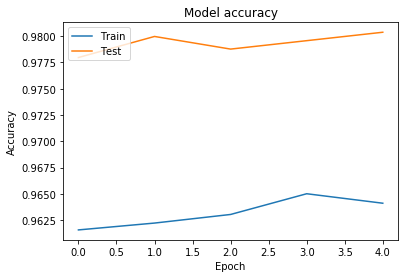

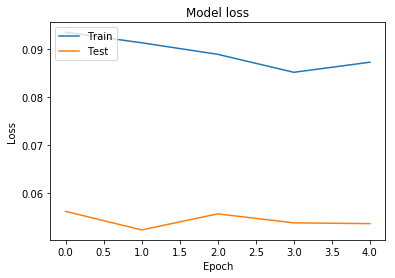

In [14]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Model-accuracy-' +str(iv3_test_scores[1]*100)+'.png')
plt.show()


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Model-loss-' +str(iv3_test_scores[1]*100)+'.png')
plt.show()